# Recipients of subsidy to private day-care and day-care of own children by region

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject
import datetime

import pandas_datareader # install with `pip install pandas-datareader`
import pydst # install with `pip install git+https://github.com/elben10/pydst`

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**$\large \color{lightblue}{Read and clean data}$**

Set up and identify the data tabel we wish to work with. 

In [132]:
# Setup data loader with the langauge 'english'
Dst = pydst.Dst(lang='en') 

# Get a list of all subjects 
Dst.get_subjects() 

# Get all tables in subject '1' (people)
tables = Dst.get_tables(subjects=['1']) 

# Display only the tables in '1' containing 'Recipients' in the text because we know that the table of interest contains this in its title 
display(tables[tables['text'].str.contains('Recipients')])

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
137,DAGTIL4,Recipients of subsidy to private day-care and ...,Number,2022-03-30 08:00:00,2008,2021,True,"[region, grant type, affected , time]"
217,HJEMSYG,Recipients of home nursing,Number,2022-06-10 08:00:00,2016,2021,True,"[region, age, sex, time]"


From running the Dst.get_subjects() we get that we have to search within the subject 'people' which is 1. 

We print a list of all of the tables within this subject. 

We only display the ones that have the word 'Recipients' in the text, because we know that the table we want, the DAGTIL4, has this in its title.


**$\large \color{lightblue}{Import}$**


In [133]:
# Importing the data from DAGTIL4
Rec_vars = Dst.get_variables(table_id='DAGTIL4')
Rec_vars

# Make the Dataframe
variables_rec = {'OMRÅDE':['*'],'TILSKUDSART':['*'],'BERORT':['*'], 'TID':['*']}
rec_gen= Dst.get_data(table_id = 'DAGTIL4', variables=variables_rec)
rec_gen.sort_values(by=['TID', 'OMRÅDE'], inplace=True)

# On municipality and year level, sum the number of recipients of each subsidy type
rec_gen = rec_gen.groupby(['OMRÅDE', 'TID', 'BERORT','TILSKUDSART']).sum().reset_index()

# Generate 1 new column for OMRÅDE AND TID with INDHOLD for BERORT = 'Children' and TILSKUDSART = 'Subsidy for day-care of own children'
rec_gen['own_child'] = rec_gen[(rec_gen['BERORT'] == 'Children') & (rec_gen['TILSKUDSART'] == 'Subsidy for day-care of own children')].groupby(['OMRÅDE', 'TID'])['INDHOLD'].transform('sum')
# Generate 1 new column for OMRÅDE AND TID with INDHOLD for BERORT = 'Children' and TILSKUDSART = 'Subsidy to parents who choose private day-care'
rec_gen['pri_child'] = rec_gen[(rec_gen['BERORT'] == 'Children') & (rec_gen['TILSKUDSART'] == 'Subsidy to parents who choose private day-care')].groupby(['OMRÅDE', 'TID'])['INDHOLD'].transform('sum')

# Generate 1 new column for OMRÅDE AND TID with INDHOLD for BERORT = 'Families' and TILSKUDSART = 'Subsidy to parents who choose private day-care'
rec_gen['pri_fam'] = rec_gen[(rec_gen['BERORT'] == 'Families') & (rec_gen['TILSKUDSART'] == 'Subsidy to parents who choose private day-care')].groupby(['OMRÅDE', 'TID'])['INDHOLD'].transform('sum')
# Generate 1 new column for OMRÅDE AND TID with INDHOLD for BERORT = 'Families' and TILSKUDSART = 'Subsidy to parents who choose private day-care'
rec_gen['own_fam'] = rec_gen[(rec_gen['BERORT'] == 'Families') & (rec_gen['TILSKUDSART'] == 'Subsidy for day-care of own children')].groupby(['OMRÅDE', 'TID'])['INDHOLD'].transform('sum')

# Replace NaN with 0
rec_gen = rec_gen.fillna(0)
# Replace .. with 0
rec_gen = rec_gen.replace('..', 0)

# drop the INDHOLD, BERORT and TILSKUDSART columns
rec_gen = rec_gen.drop(columns=['INDHOLD','BERORT', 'TILSKUDSART'])

# Convert the own_child, pri_child, pri_fam and own_fam columns to integers
rec_gen['own_child'] = rec_gen['own_child'].astype(int)
rec_gen['pri_child'] = rec_gen['pri_child'].astype(int)
rec_gen['pri_fam'] = rec_gen['pri_fam'].astype(int)
rec_gen['own_fam'] = rec_gen['own_fam'].astype(int)

# For each OMRÅDE AND TID, sum the 'own_child', 'pri_child', 'pri_fam' and 'own_fam' columns
rec_gen = rec_gen.groupby(['OMRÅDE', 'TID']).sum().reset_index()

# Rename the columns
rec_gen = rec_gen.rename(columns={'OMRÅDE':'Municipality', 'TID':'Year'})

# Show the Dataframe
rec_gen 

,Municipality,Year,own_child,pri_child,pri_fam,own_fam
0,Aabenraa,2008,14,23,20,14
1,Aabenraa,2009,13,17,15,11
2,Aabenraa,2010,11,38,36,10
3,Aabenraa,2011,7,78,75,7
4,Aabenraa,2012,10,86,86,10
...,...,...,...,...,...,...
1330,Ærø,2017,0,18,18,0
1331,Ærø,2018,0,19,18,0
1332,Ærø,2019,0,19,19,0
1333,Ærø,2020,0,19,19,0


In [157]:
# Importing the data from BY2
By_vars = Dst.get_variables(table_id='BY2')
By_vars

# Make the Dataframe
variables_by = {'KOMK':['*'],'BYST':['*'],'ALDER':['*'], 'Tid':['*']}
by_gen= Dst.get_data(table_id = 'BY2', variables=variables_by)
by_gen.sort_values(by=['TID', 'KOMK'], inplace=True)

# Rename the columns
by_gen = by_gen.rename(columns={'KOMK':'Municipality','ALDER':'Age', 'TID':'Year'})

# Remove non-numeric characters from the "Age" column (the observations in 'Age' are of the type "51 years" and not "51") 
by_gen['Age'] = by_gen['Age'].str.replace(' years?', '', regex=True).astype(int)

# Filter the dataset to select rows where Age is between 0 and 6 years
age_0_to_6 = by_gen[(by_gen['Age'] >= 0) & (by_gen['Age'] <= 6)]

# Group the data by Municipality and Year and sum the number of persons
grouped_data = age_0_to_6.groupby(['Municipality', 'Year'])['INDHOLD'].sum()

# Convert the "Age" column to string type
by_gen['Age'] = by_gen['Age'].astype(str)

# Remove non-numeric characters from the "Age" column
by_gen['Age'] = by_gen['Age'].str.replace(' years?', '', regex=True).astype(int)

# Filter the dataset to select rows where Age is between 0 and 6 years
age_0_to_6 = by_gen[(by_gen['Age'] >= 0) & (by_gen['Age'] <= 6)]

# Group the data by Municipality and Year and sum the number of persons
grouped_data = age_0_to_6.groupby(['Municipality', 'Year'])['INDHOLD'].sum().reset_index()
grouped_data = grouped_data.rename(columns={'INDHOLD': 'Residents aged 0-6 years'})

# Add a new column for the total number of residents
total_residents = by_gen.groupby(['Municipality', 'Year'])['INDHOLD'].sum().reset_index()
total_residents = total_residents.rename(columns={'INDHOLD': 'Total number of residents'})

# Merge the two dataframes
data2 = pd.merge(grouped_data, total_residents, on=['Municipality', 'Year'])

# Print the result
data2

,Municipality,Year,Residents aged 0-6 years,Total number of residents
0,Aabenraa,2010,2414,29913
1,Aabenraa,2011,2381,29795
2,Aabenraa,2012,2321,29704
3,Aabenraa,2013,2221,29536
4,Aabenraa,2014,2122,29386
...,...,...,...,...
1282,Ærø,2018,139,3094
1283,Ærø,2019,133,3021
1284,Ærø,2020,119,2990
1285,Ærø,2021,127,3003


**$\large \color{lightblue}{Merge}$** 

In [162]:
one2one = pd.merge(data2,rec_gen,on=['Municipality', 'Year'],how='inner') # Merge the two dataframes by Municipality and Year
one2one

,Municipality,Year,Residents aged 0-6 years,Total number of residents,own_child,pri_child,pri_fam,own_fam
0,Aabenraa,2010,2414,29913,11,38,36,10
1,Aabenraa,2011,2381,29795,7,78,75,7
2,Aabenraa,2012,2321,29704,10,86,86,10
3,Aabenraa,2013,2221,29536,1,120,113,1
4,Aabenraa,2014,2122,29386,0,161,157,0
...,...,...,...,...,...,...,...,...
1137,Ærø,2017,145,3110,0,18,18,0
1138,Ærø,2018,139,3094,0,19,18,0
1139,Ærø,2019,133,3021,0,19,19,0
1140,Ærø,2020,119,2990,0,19,19,0


Now we want to examine each variable

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

Et interaktivt plot hvor man kan klikke rundt mellem kommuner? 

Text(0, 0.5, 'Residents aged 0-6 years')

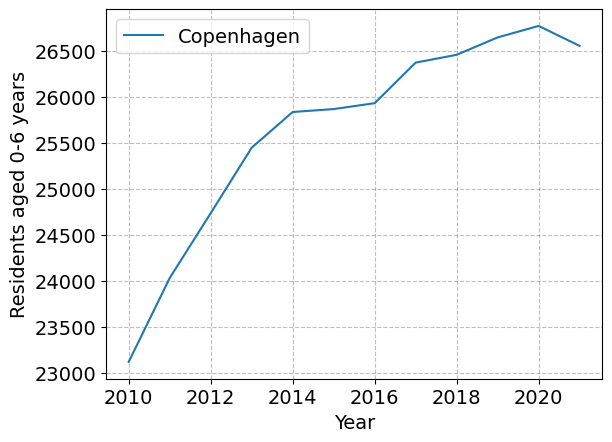

In [163]:
# create a pivot table
one2one_pivot = one2one.pivot_table(index='Municipality', columns='Year', values='Residents aged 0-6 years')

municipalities = ['Copenhagen']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Here we use the fact that the index has multiple levels (years) for an elegant loop
for m in municipalities:
    one2one_pivot.xs(m).plot(x='year',y='Residents aged 0-6 years',ax=ax,label=m)

ax.legend(frameon=True)
ax.set_ylabel('Residents aged 0-6 years')


**Interactive plot** :

In [ ]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.